**Project Assignment - 02806 Social Data Analysis and Visualization, DTU, spring 2021** <br>
Erla Hrafnkelsdóttir, Mikkel Gallus Thang and Sandra Karlsdóttir

# Project Assignment B: Fires in London

For the final project in **Social Data Analysis and Visualization** we investigate fire and rescue incidents in London from 2009 to today based on various attributes from numerous datasets. Below is a video from Project Assignment A, explaining the idea behind this and a proposal of an implementation plan. After that, Project Assignment B takes over.

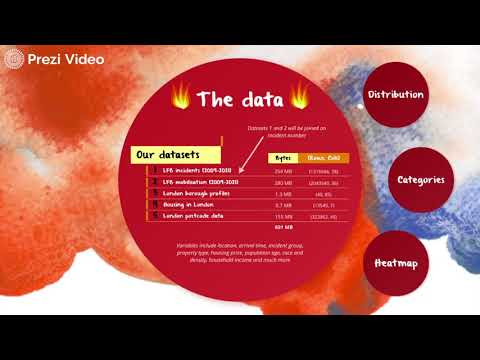

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo("EbPfJf85ilw", width = 800, height = 450)

## Imports

In [2]:
import pandas as pd
import numpy as np
import pickle
import folium
import missingno as msno
import matplotlib.pyplot as plt
from PyBNG import PyBNG
from folium import plugins
from folium.plugins import HeatMap
import seaborn as sns
sns.set()

## 1 Motivation

* **What is your dataset?**

We use seven different datasets for our project:

1. [London Fire Brigade Incident Records](https://data.london.gov.uk/dataset/london-fire-brigade-incident-records)
2. [London Fire Brigade Mobilisation Records](https://data.london.gov.uk/dataset/london-fire-brigade-mobilisation-records)
3. [London Borough Profiles and Atlas](https://data.london.gov.uk/dataset/london-borough-profiles)
4. [Houes Ages in London](https://data.cdrc.ac.uk/dataset/dwelling-ages-and-prices/resource/dwelling-age-group-counts-lsoa)
5. [Housing in London](https://www.kaggle.com/justinas/housing-in-london)
6. [UK Postcodes](https://www.doogal.co.uk/UKPostcodes.php)
7. [Boundary Files for London](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london)

The London Fire Brigade datasets are the main ones and have data from 2009-2021. They are merged together on incident number. The other datasets are used to enrich that data and allow us to dig deeper in our analysis. They are merged with our LFB datasets using post- or areacodes.

* **Why did you choose this/these particular dataset(s)?**

When brainstorming what kind of dataset to use for this project, we decided we wanted to work with something similar to police data - data that has a lot of different attributes and many records. We thought of fire data and landed on two connected datasets from London Fire Brigade. These datasets were chosen due to their high amount of both records and attributes. Given that the London Fire Brigade is one of the biggest and busiest fire and rescure services in the world [[1]](https://www.london-fire.gov.uk/about-us/), it was also the obvious choice in search of information regarding fire incdidents. 

Five additional datasets are used in combination with the datasets acquired from London Fire Brigade. These are listed above and include data on house prices and building periods in London, data on demographic, economic, social and environmental factors for each borough of London and then shapefiles of the boroughs to use for map plotting. Additionally, a dataset with all UK postcodes was used to make connections between datasets which didn't have the same post- or areacode columns.

* **What was your goal for the end user's experience?**

Since the datasets are so large and have so many different attributes, it was hard to come up with one specific research question - we wanted to explore so many different things. Therefore our goal for the end user's experience is to get a broad view over the work London Fire Brigade does and whether there is some correlation between incidents and other demographic information. 

## 2 Basic stats

### 2.1 Data processing

* **Write about your choices in data cleaning and preprocessing.**

All incident data from London Fire Brigade from 2009 to 2021 is first retrieved and concatenated:

In [2]:
# Recieve all years
lfb_i1 = pd.read_excel('LFB Incident data from January 2009 to December 2012.xlsx')
lfb_i2 = pd.read_excel('LFB Incident data from January 2013 to December 2016.xlsx')
lfb_i3 = pd.read_excel('LFB Incident data from January 2017.xlsx')

# Concatenate all years
lfb_i_frames = [lfb_i1, lfb_i2, lfb_i3]
lfbi_data = pd.concat(lfb_i_frames)

Geographical locations of incidents are considered of big importance. However, unlike the other accompanied datasets, the entries in the LFB datasets contains `Easting_rounded` and `Northing_rounded` values instead of longitude and latitude. Hence, supporting columns of longitudes and latitudes are added using the library `PyBNG`:

In [4]:
# init empty columns
lfbi_data['Latitude'] = np.nan
lfbi_data['Longitude'] = np.nan

# Calculate lon and lat
for idx, row in lfbi_data.iterrows():
    
    try:
        lat = PyBNG(easting = row['Easting_rounded'], northing = row['Northing_rounded']).get_latlon()[0]
        lfbi_data.at[idx, 'Latitude'] = lat
    except:
        lfbi_data.at[idx, 'Latitude'] = np.nan
        
    try:
        lon = PyBNG(easting = row['Easting_rounded'], northing = row['Northing_rounded']).get_latlon()[1]
        lfbi_data.at[idx, 'Longitude'] = lon
    except:
        lfbi_data.at[idx, 'Longitude'] = np.nan

With help from the library `missingno`, we can visually get a good grasp of the amount of missing datapoints (`NaN` values) for each attribute in the dataset.

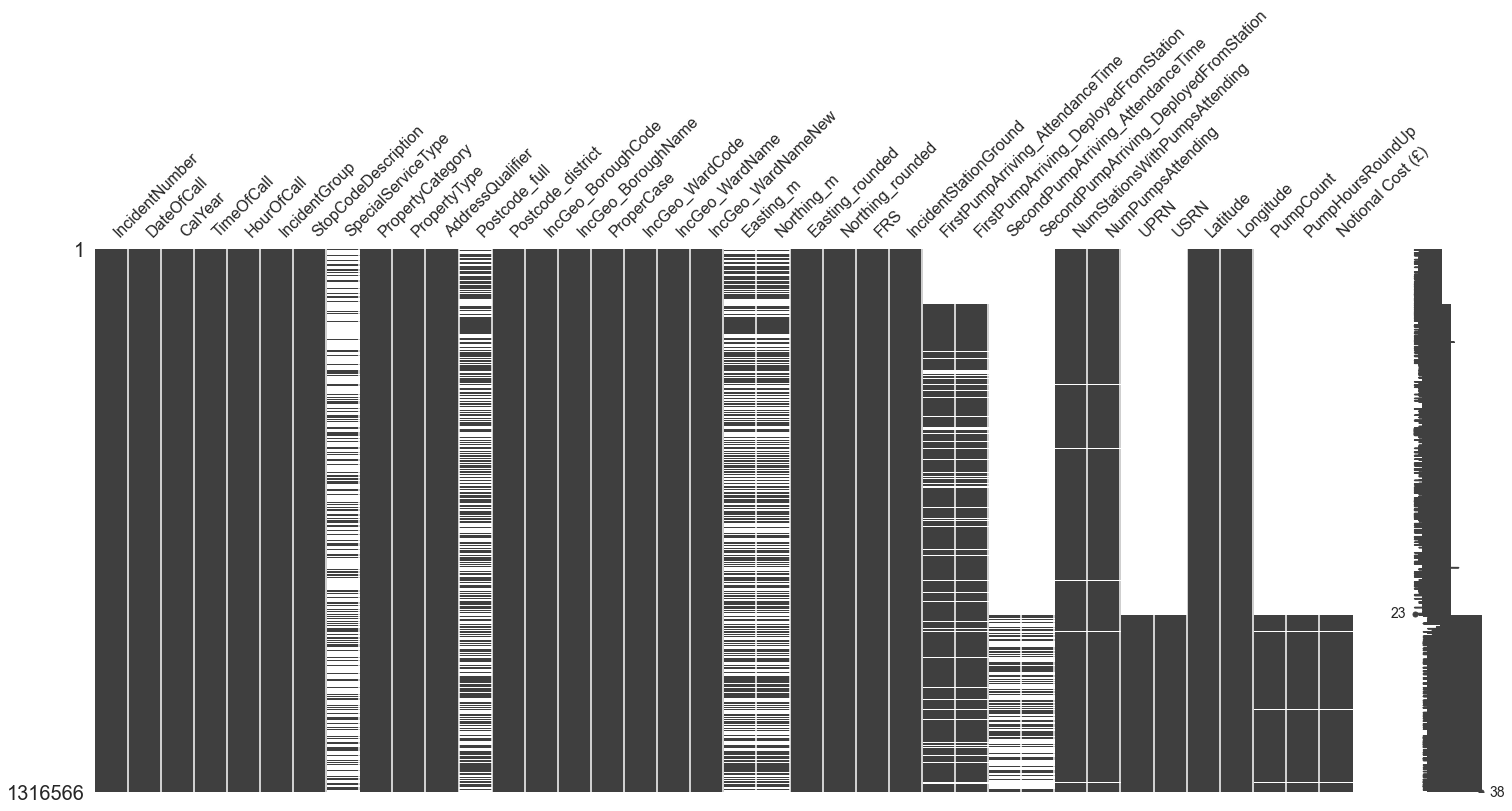

In [5]:
msno.matrix(lfbi_data)
plt.show()

It is clear that important attributes containing incident numbers, date and time, property information and geograpical positions generally do not suffer from lacking information.

On the other hand however, attribues such as `SpecialServiceType`, `National Cost` and pump related features can't be considered guaranteed information.

It so happens that there are only 31 columns in the datasets from 2009-2012 and 2013-2016, whereas there are 38 in the 2017+ dataset - i.e. there are 7 new columns in the newest dataset. These "newly" supplied attributes are: 

* `UPRN`
* `USRN`
* `Latitude`
* `Longitude`
* `PumpCount`
* `PumpHoursRoundUp`
* `National Cost (£)`

As of now, all the columns are present in the merged dataframe with `NaN` values for the older years.

As it is ecpected that the day of the week and month of the year influence the amount and handling of fires in London, columns with according information are also appended to the dataframe based on `DateOfCall`.

In [6]:
lfbi_data['Month'] = pd.DatetimeIndex(lfbi_data['DateOfCall']).month - 1
lfbi_data['MonthName'] = pd.DatetimeIndex(lfbi_data['DateOfCall']).month_name()
lfbi_data['Weekday'] = pd.DatetimeIndex(lfbi_data['DateOfCall']).weekday
lfbi_data['WeekdayName'] = pd.DatetimeIndex(lfbi_data['DateOfCall']).day_name()

The incident and mobilisation datasets from London Fire Brigade share the same `IncidentNumber` value. As the mobilisation sets contain critical performance information on each incident, these datasets are acquired and merged with the prepared incident dataset.

In [8]:
# Read all datafiles
lfb_m1 = pd.read_excel('LFB Mobilisation data from Jan2009-Dec2012.xlsx')
lfb_m2 = pd.read_excel('LFB Mobilisation data from Jan 2013.xlsx')
lfb_m3 = pd.read_excel('LFB Mobilisation data from January 2017.xlsx')

# Concatenate all years
lfb_m_frames = [lfb_m1, lfb_m2, lfb_m3]
lfbm_data = pd.concat(lfb_m_frames)

In [9]:
lfb_data = pd.merge(lfbi_data, lfbm_data, how="inner", on="IncidentNumber")

Now, let's check how big our total LFB dataset is:

In [13]:
print('Total LFB dataset size: {}'.format(lfb_data.shape))

Total LFB dataset size: (2038868, 77)


Given it's big size with over 2 million entries and 77 features, the dataset takes a long time to load. The dataframe will hence be saved using `pickle` and loaded from this instance as `firedata`.

In [16]:
pd.to_pickle(lfb_data, "./firedata.pkl")

## <font color = "red"> START HERE -> remove when notebook is ready </font>

In [3]:
firedata = pd.read_pickle("./firedata.pkl")

The combined set of data can now be inspected:

In [22]:
pd.set_option('display.max_columns', None)
firedata.head()

IncidentNumber DateOfCall  CalYear TimeOfCall  HourOfCall    IncidentGroup  \
0      235138081 2009-01-01     2009   00:00:37           0  Special Service   
1      235138081 2009-01-01     2009   00:00:37           0  Special Service   
2           2091 2009-01-01     2009   00:03:00           0             Fire   
3           3091 2009-01-01     2009   00:04:27           0             Fire   
4           5091 2009-01-01     2009   00:05:39           0             Fire   

  StopCodeDescription SpecialServiceType PropertyCategory  \
0     Special Service                RTC     Road Vehicle   
1     Special Service                RTC     Road Vehicle   
2      Secondary Fire                NaN          Outdoor   
3      Secondary Fire                NaN          Outdoor   
4      Secondary Fire                NaN          Outdoor   

                                  PropertyType  \
0                                         Car    
1                                         Car    
2                       Road surface/pavement    
3  Domestic garden (vegetation not equipment)    
4        Cycle path/public footpath/bridleway    

                        AddressQualifier Postcode_full Postcode_district  \
0  In street close to gazetteer location      SW11 4LB              SW11   
1  In street close to gazetteer location      SW11 4LB              SW11   
2   In street outside gazetteer location        N9 9EL                N9   
3       On land associated with building      UB10 0DG              UB10   
4   In street outside gazetteer location        N7 8HG                N7   

  IncGeo_BoroughCode IncGeo_BoroughName  ProperCase IncGeo_WardCode  \
0          E09000032         WANDSWORTH  Wandsworth       E05000620   
1          E09000032         WANDSWORTH  Wandsworth       E05000620   
2          E09000010            ENFIELD     Enfield       E05000201   
3          E09000017         HILLINGDON  Hillingdon       E05000332   
4          E09000019          ISLINGTON   Islington       E05000375   

   IncGeo_WardName IncGeo_WardNameNew  Easting_m  Northing_m  Easting_rounded  \
0       Queenstown         Queenstown   528652.0    176830.0           528650   
1       Queenstown         Queenstown   528652.0    176830.0           528650   
2        Haselbury          Haselbury   533773.0    194492.0           533750   
3  Hillingdon East    Hillingdon East   507738.0    182805.0           507750   
4         Holloway           Holloway   531058.0    185307.0           531050   

   Northing_rounded     FRS IncidentStationGround  \
0            176850  London             Battersea   
1            176850  London             Battersea   
2            194450  London              Edmonton   
3            182850  London            Hillingdon   
4            185350  London              Holloway   

   FirstPumpArriving_AttendanceTime FirstPumpArriving_DeployedFromStation  \
0                               NaN                                   NaN   
1                               NaN                                   NaN   
2                               NaN                                   NaN   
3                               NaN                                   NaN   
4                               NaN                                   NaN   

   SecondPumpArriving_AttendanceTime SecondPumpArriving_DeployedFromStation  \
0                                NaN                                    NaN   
1                                NaN                                    NaN   
2                                NaN                                    NaN   
3                                NaN                                    NaN   
4                                NaN                                    NaN   

   NumStationsWithPumpsAttending  NumPumpsAttending  UPRN  USRN   Latitude  \
0                            2.0                2.0   NaN   NaN  51.634235   
1                            2.0                2.0   NaN   NaN  51.6

<font color = "red"> We can see that the last few columns in the combined dataset seem to have a lot of `NaN` values so the project's emphasis will rely more on the incident dataset rather than the mobilisation one.

### 2.2 Data statistics

* **Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.**

Provided our newly prepared indicent and mobilisation dataset, we can investigate which type of incidents occur most often:

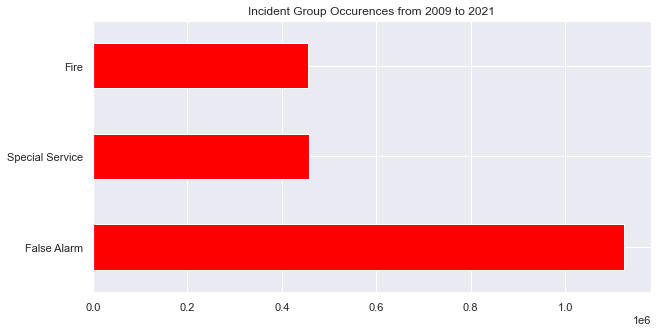

In [36]:
ig = firedata["IncidentGroup"].value_counts()
ig.plot.barh(title = 'Incident Group Occurences from 2009 to 2021', color = 'red', figsize = (10,5));

Quite interestingly, false alarms occur more often than both fires ans special services, combined!

Someone smart once said *rather be safe than sorry*, however given LFB is government funded, this will without doubt be a big cost for the system. We can with data collected from 2017 and onwards estimate the actual cost of these false alarms:

In [40]:
fa = firedata[(firedata["IncidentGroup"] == 'False Alarm') & (firedata["CalYear"] >= 2017)]
print('Amount of false alarms reported 2017 and onwards: {}'.format(len(fa)))
fa_cost = fa['Notional Cost (£)'].sum()
print('Total national cost: {} £'.format(fa_cost))

Amount of false alarms reported 2017 and onwards: 376103
Total national cost: 149374843.0 £


In total, the govenment has spent just below 150 million pounds on false alarms since 2017!

Another fun and descriptive visualisation is how the incident stop code is divided:

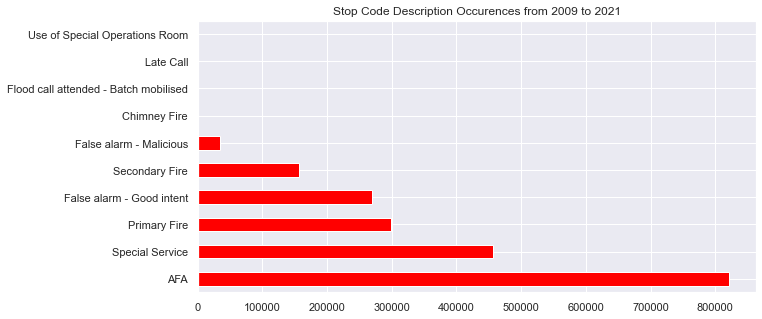

In [37]:
scd = firedata["StopCodeDescription"].value_counts()
scd.plot.barh(title = 'Stop Code Description Occurences from 2009 to 2021', color = 'red', figsize = (10,5));

The AFA (Automatic Fire Alarm) system is responsible for the vast majority of reported incidents. We can investigate the amount of AFA calls that are responsible for false alarms too:

In [41]:
fa_afa = firedata[(firedata["IncidentGroup"] == 'False Alarm') & (firedata["CalYear"] >= 2017) & (firedata["StopCodeDescription"] == 'AFA')]
print('Amount of false alarms caused by AFA reported 2017 and onwards: {}'.format(len(fa_afa)))
print('Shares of false alarms causes by AFA out of all: {:.2f}%'.format(len(fa_afa)/len(fa)*100))

fa__afa_cost = fa_afa['Notional Cost (£)'].sum()
print('Total national cost: {} £'.format(fa__afa_cost))
print('Shares of national cost (AFA): {:.2f}%'.format(fa__afa_cost/fa_cost*100))

Amount of false alarms caused by AFA reported 2017 and onwards: 284138
Shares of false alarms causes by AFA out of all: 75.55%
Total national cost: 109467889.0 £
Shares of national cost (AFA): 73.28%


It is clear that the AFA system is rensponsible for too many false alarms, with costs reaching almost 110 million pounds in just over 3 years of time. This actually happens to be a problem not just in England, but all around the world. The Australian fire and rescure service for instance has comitted to taking necesarry measures to bring their amount of false AFA calls down: https://www.fire.nsw.gov.au/page.php?id=77.

We can also investigate which type of special services are used most often:

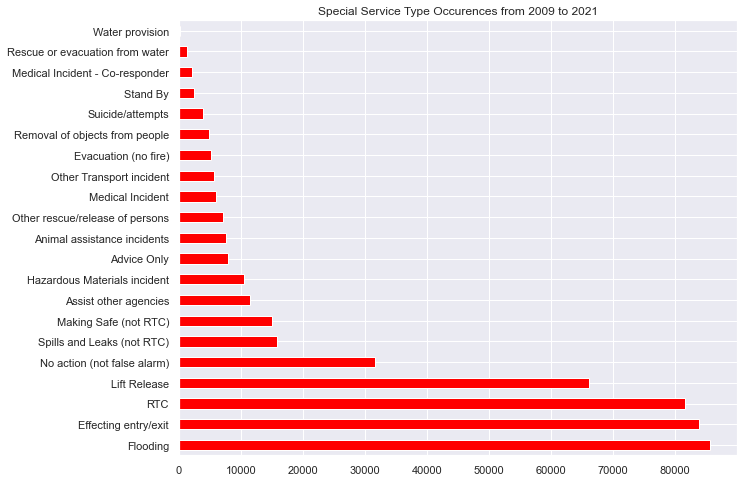

In [25]:
sst = firedata["SpecialServiceType"].value_counts()
sst.plot.barh(figsize = (10,8), title = 'Special Service Type Occurences from 2009 to 2021', color = 'red');

Incidents are also reported from numerous different property categories:

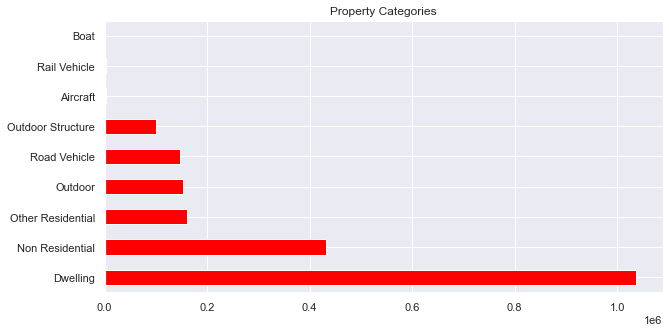

In [42]:
pc = firedata["PropertyCategory"].value_counts()
pc.plot.barh(title = 'Property Categories', color = 'red', figsize = (10,5));

This, however, only covers major categories. As it turns out, there is a much larger amount of property types:

In [28]:
pt = firedata["PropertyType"].unique()
print('Amount of unique property types: {}'.format(len(pt)))

Amount of unique property types: 293


The dataset also holds address specific information which might maybe be useful in later analysis using machine learning, given that this most likely affects response and handling time.

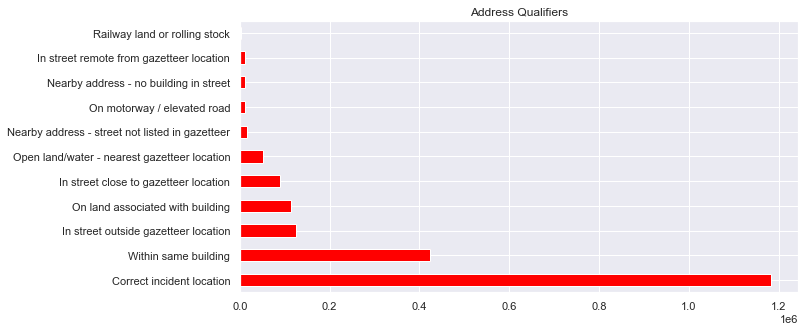

In [43]:
aq = firedata["AddressQualifier"].value_counts()
aq.plot.barh(title = 'Address Qualifiers', color = 'red', figsize = (10,5));

The data has lots and lots of attributes but here we have covered the main ones which we think would be most interesting for analysis.

## 3 Data Analysis

* **Describe your data analysis and explain what you've learned about the dataset.**
* **If relevant, talk about your machine-learning.**

Both of these questions will be addressed in the following sections.

### 3.1 Critical areas

To get a better understanding of the incidents acted upon, and for potential firefighters to be better prepared for future reported incidents, it is extremely important to know which areas require the most focus.

For this reason, we start by investigating which areas in London have the highest amount of reported incidetns using Folium heatmaps. A function to generate a heatmap is made below. 

In [28]:
def ldn_heatmap(firedata, zoom):
    # Starting points
    london_lat = 51.5074
    london_lon = 0.1278
    ldnheat = folium.Map(location = [london_lat, london_lon], tiles = "Stamen Terrain", zoom_start = zoom) 
    
    # Subtract only longitude and latitude points from the dataset
    heat_df = firedata
    heat_df = firedata[['Latitude', 'Longitude']]
    
    # And delete NA values, if there are any
    heat_df = heat_df.dropna(axis = 0, subset = ['Latitude','Longitude'])

    # List comprehension to make out list of lists
    heat_data = [[row['Latitude'], row['Longitude']] for index, row in heat_df.iterrows()]

    # Plot the map
    HeatMap(heat_data).add_to(ldnheat)

    # Display the map
    return ldnheat

Given that we have so many datapoints, we decided to start by making a heatmap only for incidents in the **year 2020:**

In [29]:
heat_df = firedata[(firedata['CalYear']==2020)]
ldn_heatmap(heat_df, 10)    

We can see that the heatmap basically turns into one, big, red blob when viewing London as a whole on the map. If one zooms in a lot, the hotspots are somewhat distinguishable, but it's hard to make any conclusion based on this. So, the next step is to view smaller time intervals - let's check out what the newest date in the dataset is:

In [30]:
print('Newest date: ', max(firedata['DateOfCall']))

Newest date:  2021-02-28 00:00:00


Based on this, let's try out plotting the newest month in the dataset, **February of 2021:**

In [31]:
heat_df = firedata[(firedata['CalYear']==2020) & (firedata['Month']==2)]
ldn_heatmap(heat_df, 10)

This is still a lot of data! Now let's try plotting the newest week in the dataset, **week 8 of 2021:**

In [32]:
heat_df = firedata[firedata['DateOfCall'] >= '2021-02-22']
ldn_heatmap(heat_df, 10)    

This is looking better and a little more distinguishable, but it's obvious that LFB is an *extremely* busy organization. So lastly, let's look at data for one day, the newest one, **February 28th of 2021:**

In [33]:
heat_df = firedata[firedata['DateOfCall'] == '2021-02-28']
ldn_heatmap(heat_df, 10)    

Here, we can finally see some distinction between different areas. The hottest areas seem to be just southwest of the city center - at least for that specific day.

### 3.2 Interactive stats

In [25]:
output_notebook(resources = None, verbose = False, hide_banner = False, load_timeout = 5000, notebook_type = 'jupyter')

def bkFireApp(isNotebook):
    def bkFire(doc):
        df = sample.copy()

        # Prepare axes
        x_axis = Select(title="X Axis (Time)", options=list(x_map.keys()), value="Hourly")
        y_axis = Select(title="Y Axis (Occurances)", options=list(y_map.keys()), value="Incident Group")
        data_edit = Select(title="Data manipulation", options=list(data_map.keys()), value="Normalized")

        def filterData():
            # Group the data by selected time
            group_count = df.groupby([y_map[y_axis.value], x_map[x_axis.value]['id']]).size().unstack(y_map[y_axis.value])
            groups = list(group_count.columns)

            if data_map[data_edit.value]:
                # Normalize the data
                total_group = [] 
                for col in group_count:
                    total_group.append(sum(group_count[col]))
                group_count = group_count / total_group

            # Add the time to the normalized dataframe
            time = x_map[x_axis.value]['time']
            group_count["time"] = time

            # Update color palette
            color_split = len(colors_all) // len(groups)
            colors = [c for i, c in enumerate(colors_all) if i % color_split == 0]

            return group_count, groups, time, colors

        def updatePlot():
            df, groups, time, colors = filterData()

            # Prepare the data to be added to the Bokeh graph
            source = ColumnDataSource(df)
            p = figure(x_range = FactorRange(factors = time),
                       title = '{}: {} View, {} Data'.format(y_axis.value,x_axis.value,data_edit.value),
                       plot_width = 900, plot_height = 550, toolbar_location='above')
            bar = {} # to store vbars
            items = []

            for i, group in enumerate(groups):
                strengur = colors[i-1]
                bar[group] = p.vbar(x = 'time', top = group, fill_color = strengur, source = source, muted_alpha = 0.05, muted = True, width = 0.8) 
                items.append((group, [bar[group]])) 

            # Move the legend outside of the figure
            legend = Legend(items = items) 
            p.add_layout(legend, 'right')

            p.legend.click_policy = "mute"

            # Show standard static output for notebook ( NOT FULLY INTERACTIVE VERSION )
            if isNotebook:
                show(p)
            else:
                # Clear former figure and add new modified
                doc.clear()
                doc.add_root(column(row(controls), p))

        # Set axis controls
        controls = [x_axis, y_axis, data_edit]
        for control in controls:
            control.on_change('value', lambda attr, old, new: updatePlot())

        # Initial data load
        updatePlot()
        
        # Set theme
        if not isNotebook:
            doc.theme = Theme(json=yaml.load("""
                attrs:
                    Figure:
                        outline_line_color: white
                        toolbar_location: above
                        height: 550
                        width: 900
                    Grid:
                        grid_line_dash: [6, 4]
            """, Loader=yaml.FullLoader))
    
    # Show Bokeh plot
    show(bkFire)

# Run app
bkFireApp(True) # For interactive version, change to 'False'

Loading BokehJS ...

## 4 Genre 
* **Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?**
* **Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?**

## 5 Visualizations
* **Explain the visualizations you've chosen.**
* **Why are they right for the story you want to tell?**

## 6 Discussion
* **What went well?**
* **What is still missing? What could be improved? Why?**

## 7 Contributions
* **You should write (just briefly) which group member was the main responsible for which elements of the assignment.**